# ERA5 composites of tracked convective cells 

**TO DO**

- select timeslots (e.g. 3 hour before initiation of system over the plateau, system from south is transported to plateau, no cloud system, dissipation)
- build composite 

- calculate wind shear, wind vectors, etc 
- plot characteristics 



In [62]:
## This function downloads ERA5 large-scale parameters for specifief timepoint 

def download_era5_synoptic(year, month, daty, hour, composite): 
    # input parameter: year,month, day, hour as str; composite is a str to describe composite feature (e.g. CS initiation)
    
    import cdsapi                                                                                           
    # Open a new Client instance                                                                            
    c = cdsapi.Client()         
    # output filename 
    file= 'composites/era5_'+ composite+'_'+ year + month+ day+ hour+ '.nc'
    # Send request (download data)                                                                     
    c.retrieve('reanalysis-era5-pressure-levels', {                                                           
            "product_type":   "reanalysis",                                                                 
            "format":         "netcdf",                                                                     
            "area":           "50.00/60.00/20.00/120.00",                                                   
            "variable":       [                                                                             
                'u_component_of_wind','v_component_of_wind', 'geopotential' , 'vertical_velocity', 'vorticity' , 'relative_humidity'                                                                                              
            ],                                                                                              
            "year":           [year],                                                      
            "month":          [month],                
            "day":            [day],                               
            "time":           [                                                                             
                hour                                                                     
            ]                                                                                               
        }, file)                                                                

    print(file, 'downloaded and saved.')   
    

In [15]:
year = '2000'
month= '07'
day= '10'
hour='12'


download_era5_synoptic(year, month, day, hour)                                     
                                      

2020-02-25 10:10:54,132 INFO Welcome to the CDS
2020-02-25 10:10:54,135 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-02-25 10:10:54,520 INFO Request is completed
2020-02-25 10:10:54,522 INFO Downloading http://136.156.133.37/cache-compute-0011/cache/data4/adaptor.mars.internal-1582621716.2596722-1804-5-609c9d99-c7b8-49b2-ae47-52146cb19da4.nc to era5_pressure_levels2000071012.nc (2M)
2020-02-25 10:10:54,971 INFO Download rate 4.5M/s   


era5_pressure_levels2000071012.nc downloaded and saved.


In [60]:
# read in dataframe with features/ tracks 
import pandas as pd 

path = '/media/juli/Data/projects/data/satellite_data/ncep/ctt/Save/tbb230'
feature_data = path+'/Features_cells_200005.h5'
features = pd.read_hdf(feature_data, 'table')

In [54]:
# subselect features and create time list for composites

cold_features = features[features.threshold_value < 200]

years =np.array(())
months= np.array(())
days= np.array(())
hours= np.array(())

for t in cold_features.time.values:
    years.append(t.year)
    months.append(t.month)
    days.append(t.day)
    hours.append(t.hour)


## Download composites : example

In [64]:
for i,year in enumerate(years):
    year = str(year)
    month= str(months[i])
    day= str(days[i])
    hour= str(hours[i])
    download_era5_synoptic(year, month, day, hour, composite= 'testcomposite')      
    

2020-02-25 11:07:03,358 INFO Welcome to the CDS
2020-02-25 11:07:03,359 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-02-25 11:07:03,771 INFO Request is queued
2020-02-25 11:07:04,807 INFO Request is running
2020-02-25 11:07:12,037 INFO Request is completed
2020-02-25 11:07:12,038 INFO Downloading http://136.156.132.201/cache-compute-0004/cache/data8/adaptor.mars.internal-1582625223.831881-22708-31-06be208d-8b0e-4fda-b3f6-9e2c62b9187a.nc to composites/era5_testcomposite_20005212.nc (2M)
2020-02-25 11:07:12,465 INFO Download rate 4.7M/s   
2020-02-25 11:07:13,165 INFO Welcome to the CDS
2020-02-25 11:07:13,166 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels


composites/era5_testcomposite_20005212.nc downloaded and saved.


2020-02-25 11:07:13,721 INFO Request is queued
2020-02-25 11:07:14,757 INFO Request is running
2020-02-25 11:07:21,994 INFO Request is completed
2020-02-25 11:07:21,994 INFO Downloading http://136.156.133.37/cache-compute-0011/cache/data4/adaptor.mars.internal-1582625233.8740933-23447-23-a1e11d0e-f419-4293-8c2f-7e8898d4d8f1.nc to composites/era5_testcomposite_20005911.nc (2M)
2020-02-25 11:07:22,417 INFO Download rate 4.8M/s   
2020-02-25 11:07:23,121 INFO Welcome to the CDS
2020-02-25 11:07:23,121 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels


composites/era5_testcomposite_20005911.nc downloaded and saved.


2020-02-25 11:07:23,812 INFO Request is completed
2020-02-25 11:07:23,813 INFO Downloading http://136.156.133.37/cache-compute-0011/cache/data4/adaptor.mars.internal-1582625233.8740933-23447-23-a1e11d0e-f419-4293-8c2f-7e8898d4d8f1.nc to composites/era5_testcomposite_20005911.nc (2M)
2020-02-25 11:07:24,346 INFO Download rate 3.8M/s   
2020-02-25 11:07:24,526 INFO Welcome to the CDS
2020-02-25 11:07:24,527 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels


composites/era5_testcomposite_20005911.nc downloaded and saved.


2020-02-25 11:07:25,116 INFO Request is queued
2020-02-25 11:07:26,151 INFO Request is running
2020-02-25 11:07:33,388 INFO Request is completed
2020-02-25 11:07:33,389 INFO Downloading http://136.156.132.236/cache-compute-0007/cache/data3/adaptor.mars.internal-1582625245.4757342-2407-17-29f7eb89-8027-403b-a7c1-d8682f531dcc.nc to composites/era5_testcomposite_20005912.nc (2M)
2020-02-25 11:07:33,828 INFO Download rate 4.6M/s   
2020-02-25 11:07:34,170 INFO Welcome to the CDS
2020-02-25 11:07:34,170 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels


composites/era5_testcomposite_20005912.nc downloaded and saved.


2020-02-25 11:07:34,423 INFO Request is completed
2020-02-25 11:07:34,423 INFO Downloading http://136.156.132.236/cache-compute-0007/cache/data3/adaptor.mars.internal-1582625245.4757342-2407-17-29f7eb89-8027-403b-a7c1-d8682f531dcc.nc to composites/era5_testcomposite_20005912.nc (2M)
2020-02-25 11:07:34,942 INFO Download rate 3.9M/s   
2020-02-25 11:07:35,380 INFO Welcome to the CDS
2020-02-25 11:07:35,381 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels


composites/era5_testcomposite_20005912.nc downloaded and saved.


2020-02-25 11:07:35,821 INFO Request is queued
2020-02-25 11:07:36,858 INFO Request is running
2020-02-25 11:07:44,089 INFO Request is completed
2020-02-25 11:07:44,090 INFO Downloading http://136.156.133.25/cache-compute-0008/cache/data1/adaptor.mars.internal-1582625256.1250167-28587-35-766cc97a-de0f-49dd-90b9-84ca732cbe25.nc to composites/era5_testcomposite_20005913.nc (2M)
2020-02-25 11:07:44,541 INFO Download rate 4.4M/s   
2020-02-25 11:07:45,083 INFO Welcome to the CDS
2020-02-25 11:07:45,083 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels


composites/era5_testcomposite_20005913.nc downloaded and saved.


2020-02-25 11:07:45,321 INFO Request is completed
2020-02-25 11:07:45,322 INFO Downloading http://136.156.133.25/cache-compute-0008/cache/data1/adaptor.mars.internal-1582625256.1250167-28587-35-766cc97a-de0f-49dd-90b9-84ca732cbe25.nc to composites/era5_testcomposite_20005913.nc (2M)
2020-02-25 11:07:45,854 INFO Download rate 3.8M/s   
2020-02-25 11:07:46,161 INFO Welcome to the CDS
2020-02-25 11:07:46,162 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels


composites/era5_testcomposite_20005913.nc downloaded and saved.


2020-02-25 11:07:46,444 INFO Request is queued
2020-02-25 11:07:47,481 INFO Request is running
2020-02-25 11:07:54,713 INFO Request is completed
2020-02-25 11:07:54,714 INFO Downloading http://136.156.133.39/cache-compute-0012/cache/data2/adaptor.mars.internal-1582625266.6041286-6075-5-61516249-f9a3-4f1d-ae5a-125a4f2d7a67.nc to composites/era5_testcomposite_20005914.nc (2M)
2020-02-25 11:07:55,098 INFO Download rate 5.2M/s   
2020-02-25 11:07:55,376 INFO Welcome to the CDS
2020-02-25 11:07:55,377 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels


composites/era5_testcomposite_20005914.nc downloaded and saved.


2020-02-25 11:07:55,784 INFO Request is completed
2020-02-25 11:07:55,785 INFO Downloading http://136.156.133.39/cache-compute-0012/cache/data2/adaptor.mars.internal-1582625266.6041286-6075-5-61516249-f9a3-4f1d-ae5a-125a4f2d7a67.nc to composites/era5_testcomposite_20005914.nc (2M)
2020-02-25 11:07:56,229 INFO Download rate 4.5M/s   
2020-02-25 11:07:56,573 INFO Welcome to the CDS
2020-02-25 11:07:56,574 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels


composites/era5_testcomposite_20005914.nc downloaded and saved.


2020-02-25 11:07:56,913 INFO Request is queued
2020-02-25 11:07:57,948 INFO Request is running
2020-02-25 11:08:05,191 INFO Request is completed
2020-02-25 11:08:05,192 INFO Downloading http://136.156.133.42/cache-compute-0014/cache/data7/adaptor.mars.internal-1582625276.994839-1893-29-d4996adc-27c1-4e9d-8811-76bdda5e493b.nc to composites/era5_testcomposite_20005915.nc (2M)
2020-02-25 11:08:05,680 INFO Download rate 4.1M/s   
2020-02-25 11:08:06,213 INFO Welcome to the CDS
2020-02-25 11:08:06,214 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels


composites/era5_testcomposite_20005915.nc downloaded and saved.


2020-02-25 11:08:06,858 INFO Request is completed
2020-02-25 11:08:06,859 INFO Downloading http://136.156.133.42/cache-compute-0014/cache/data7/adaptor.mars.internal-1582625276.994839-1893-29-d4996adc-27c1-4e9d-8811-76bdda5e493b.nc to composites/era5_testcomposite_20005915.nc (2M)
2020-02-25 11:08:07,287 INFO Download rate 4.7M/s   
2020-02-25 11:08:08,042 INFO Welcome to the CDS
2020-02-25 11:08:08,042 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels


composites/era5_testcomposite_20005915.nc downloaded and saved.


2020-02-25 11:08:08,528 INFO Request is queued
2020-02-25 11:08:09,566 INFO Request is running
2020-02-25 11:08:16,801 INFO Request is completed
2020-02-25 11:08:16,801 INFO Downloading http://136.156.132.236/cache-compute-0007/cache/data1/adaptor.mars.internal-1582625289.2613146-350-23-53ad7d38-a19a-4e25-aa71-a35da972694d.nc to composites/era5_testcomposite_20005916.nc (2M)
2020-02-25 11:08:17,280 INFO Download rate 4.2M/s   
2020-02-25 11:08:17,619 INFO Welcome to the CDS
2020-02-25 11:08:17,619 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels


composites/era5_testcomposite_20005916.nc downloaded and saved.


2020-02-25 11:08:17,852 INFO Request is completed
2020-02-25 11:08:17,852 INFO Downloading http://136.156.132.236/cache-compute-0007/cache/data1/adaptor.mars.internal-1582625289.2613146-350-23-53ad7d38-a19a-4e25-aa71-a35da972694d.nc to composites/era5_testcomposite_20005916.nc (2M)
2020-02-25 11:08:18,328 INFO Download rate 4.2M/s   
2020-02-25 11:08:18,524 INFO Welcome to the CDS
2020-02-25 11:08:18,525 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels


composites/era5_testcomposite_20005916.nc downloaded and saved.


2020-02-25 11:08:18,755 INFO Request is queued
2020-02-25 11:08:19,792 INFO Request is running
2020-02-25 11:08:27,042 INFO Request is completed
2020-02-25 11:08:27,043 INFO Downloading http://136.156.132.236/cache-compute-0007/cache/data2/adaptor.mars.internal-1582625299.2846725-6098-3-a9c1b8a1-237d-4045-a2ea-178a7e9cf560.nc to composites/era5_testcomposite_20005917.nc (2M)
2020-02-25 11:08:27,515 INFO Download rate 4.2M/s   
2020-02-25 11:08:27,788 INFO Welcome to the CDS
2020-02-25 11:08:27,788 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels


composites/era5_testcomposite_20005917.nc downloaded and saved.


2020-02-25 11:08:28,062 INFO Request is completed
2020-02-25 11:08:28,063 INFO Downloading http://136.156.132.236/cache-compute-0007/cache/data2/adaptor.mars.internal-1582625299.2846725-6098-3-a9c1b8a1-237d-4045-a2ea-178a7e9cf560.nc to composites/era5_testcomposite_20005917.nc (2M)
2020-02-25 11:08:28,534 INFO Download rate 4.3M/s   
2020-02-25 11:08:29,147 INFO Welcome to the CDS
2020-02-25 11:08:29,147 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels


composites/era5_testcomposite_20005917.nc downloaded and saved.


2020-02-25 11:08:29,487 INFO Request is queued
2020-02-25 11:08:30,524 INFO Request is running
2020-02-25 11:08:37,760 INFO Request is completed
2020-02-25 11:08:37,761 INFO Downloading http://136.156.133.32/cache-compute-0009/cache/data5/adaptor.mars.internal-1582625309.79021-14938-35-7644eea7-cf6b-44b2-badf-21663c95b5f9.nc to composites/era5_testcomposite_20005918.nc (2M)
2020-02-25 11:08:38,233 INFO Download rate 4.3M/s   


composites/era5_testcomposite_20005918.nc downloaded and saved.


2020-02-25 11:08:39,057 INFO Welcome to the CDS
2020-02-25 11:08:39,057 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-02-25 11:08:39,364 INFO Request is completed
2020-02-25 11:08:39,364 INFO Downloading http://136.156.133.32/cache-compute-0009/cache/data5/adaptor.mars.internal-1582625309.79021-14938-35-7644eea7-cf6b-44b2-badf-21663c95b5f9.nc to composites/era5_testcomposite_20005918.nc (2M)
2020-02-25 11:08:39,878 INFO Download rate 3.9M/s   


composites/era5_testcomposite_20005918.nc downloaded and saved.


2020-02-25 11:08:40,405 INFO Welcome to the CDS
2020-02-25 11:08:40,405 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-02-25 11:08:41,015 INFO Request is completed
2020-02-25 11:08:41,017 INFO Downloading http://136.156.133.32/cache-compute-0009/cache/data5/adaptor.mars.internal-1582625309.79021-14938-35-7644eea7-cf6b-44b2-badf-21663c95b5f9.nc to composites/era5_testcomposite_20005918.nc (2M)
2020-02-25 11:08:41,498 INFO Download rate 4.2M/s   
2020-02-25 11:08:41,862 INFO Welcome to the CDS
2020-02-25 11:08:41,863 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels


composites/era5_testcomposite_20005918.nc downloaded and saved.


2020-02-25 11:08:42,618 INFO Request is completed
2020-02-25 11:08:42,620 INFO Downloading http://136.156.133.32/cache-compute-0009/cache/data5/adaptor.mars.internal-1582625309.79021-14938-35-7644eea7-cf6b-44b2-badf-21663c95b5f9.nc to composites/era5_testcomposite_20005918.nc (2M)
2020-02-25 11:08:43,101 INFO Download rate 4.2M/s   
2020-02-25 11:08:43,360 INFO Welcome to the CDS
2020-02-25 11:08:43,360 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels


composites/era5_testcomposite_20005918.nc downloaded and saved.


2020-02-25 11:08:43,943 INFO Request is queued
2020-02-25 11:08:44,978 INFO Request is running
2020-02-25 11:08:52,210 INFO Request is completed
2020-02-25 11:08:52,210 INFO Downloading http://136.156.133.36/cache-compute-0010/cache/data8/adaptor.mars.internal-1582625324.4423761-1959-11-ffd21c90-63d9-4b08-9070-8ef457ad6210.nc to composites/era5_testcomposite_20005919.nc (2M)
2020-02-25 11:08:52,597 INFO Download rate 5.2M/s   
2020-02-25 11:08:53,033 INFO Welcome to the CDS
2020-02-25 11:08:53,033 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels


composites/era5_testcomposite_20005919.nc downloaded and saved.


2020-02-25 11:08:53,267 INFO Request is completed
2020-02-25 11:08:53,267 INFO Downloading http://136.156.133.36/cache-compute-0010/cache/data8/adaptor.mars.internal-1582625324.4423761-1959-11-ffd21c90-63d9-4b08-9070-8ef457ad6210.nc to composites/era5_testcomposite_20005919.nc (2M)
2020-02-25 11:08:53,707 INFO Download rate 4.6M/s   
2020-02-25 11:08:54,313 INFO Welcome to the CDS
2020-02-25 11:08:54,313 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels


composites/era5_testcomposite_20005919.nc downloaded and saved.


2020-02-25 11:08:54,683 INFO Request is completed
2020-02-25 11:08:54,683 INFO Downloading http://136.156.133.36/cache-compute-0010/cache/data8/adaptor.mars.internal-1582625324.4423761-1959-11-ffd21c90-63d9-4b08-9070-8ef457ad6210.nc to composites/era5_testcomposite_20005919.nc (2M)
2020-02-25 11:08:55,217 INFO Download rate 3.8M/s   
2020-02-25 11:08:55,709 INFO Welcome to the CDS
2020-02-25 11:08:55,710 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels


composites/era5_testcomposite_20005919.nc downloaded and saved.


2020-02-25 11:08:55,923 INFO Request is completed
2020-02-25 11:08:55,924 INFO Downloading http://136.156.133.36/cache-compute-0010/cache/data8/adaptor.mars.internal-1582625324.4423761-1959-11-ffd21c90-63d9-4b08-9070-8ef457ad6210.nc to composites/era5_testcomposite_20005919.nc (2M)
2020-02-25 11:08:56,410 INFO Download rate 4.1M/s   
2020-02-25 11:08:56,816 INFO Welcome to the CDS
2020-02-25 11:08:56,817 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels


composites/era5_testcomposite_20005919.nc downloaded and saved.


2020-02-25 11:08:56,994 INFO Request is completed
2020-02-25 11:08:56,995 INFO Downloading http://136.156.133.36/cache-compute-0010/cache/data8/adaptor.mars.internal-1582625324.4423761-1959-11-ffd21c90-63d9-4b08-9070-8ef457ad6210.nc to composites/era5_testcomposite_20005919.nc (2M)
2020-02-25 11:08:57,472 INFO Download rate 4.2M/s   
2020-02-25 11:08:58,131 INFO Welcome to the CDS
2020-02-25 11:08:58,132 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels


composites/era5_testcomposite_20005919.nc downloaded and saved.


2020-02-25 11:08:58,824 INFO Request is queued
2020-02-25 11:08:59,860 INFO Request is running
2020-02-25 11:09:03,687 INFO Request is completed
2020-02-25 11:09:03,687 INFO Downloading http://136.156.132.201/cache-compute-0004/cache/data4/adaptor.mars.internal-1582625338.9794042-29780-19-99698f2d-7e61-47d1-a563-208845666358.nc to composites/era5_testcomposite_20005920.nc (2M)
2020-02-25 11:09:04,103 INFO Download rate 4.8M/s   
2020-02-25 11:09:04,339 INFO Welcome to the CDS
2020-02-25 11:09:04,339 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels


composites/era5_testcomposite_20005920.nc downloaded and saved.


2020-02-25 11:09:04,578 INFO Request is completed
2020-02-25 11:09:04,578 INFO Downloading http://136.156.132.201/cache-compute-0004/cache/data4/adaptor.mars.internal-1582625338.9794042-29780-19-99698f2d-7e61-47d1-a563-208845666358.nc to composites/era5_testcomposite_20005920.nc (2M)
2020-02-25 11:09:04,991 INFO Download rate 4.9M/s   
2020-02-25 11:09:05,201 INFO Welcome to the CDS
2020-02-25 11:09:05,202 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels


composites/era5_testcomposite_20005920.nc downloaded and saved.


2020-02-25 11:09:05,597 INFO Request is completed
2020-02-25 11:09:05,597 INFO Downloading http://136.156.132.201/cache-compute-0004/cache/data4/adaptor.mars.internal-1582625338.9794042-29780-19-99698f2d-7e61-47d1-a563-208845666358.nc to composites/era5_testcomposite_20005920.nc (2M)
2020-02-25 11:09:06,024 INFO Download rate 4.7M/s   
2020-02-25 11:09:06,281 INFO Welcome to the CDS
2020-02-25 11:09:06,282 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels


composites/era5_testcomposite_20005920.nc downloaded and saved.


2020-02-25 11:09:06,522 INFO Request is queued
2020-02-25 11:09:07,558 INFO Request is running
2020-02-25 11:09:11,384 INFO Request is completed
2020-02-25 11:09:11,385 INFO Downloading http://136.156.133.32/cache-compute-0009/cache/data8/adaptor.mars.internal-1582625346.8464572-18363-13-783672c2-3367-43c9-9d68-8399a813fd8b.nc to composites/era5_testcomposite_20005921.nc (2M)
2020-02-25 11:09:11,928 INFO Download rate 3.7M/s   
2020-02-25 11:09:12,131 INFO Welcome to the CDS
2020-02-25 11:09:12,132 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels


composites/era5_testcomposite_20005921.nc downloaded and saved.


2020-02-25 11:09:12,383 INFO Request is completed
2020-02-25 11:09:12,383 INFO Downloading http://136.156.133.32/cache-compute-0009/cache/data8/adaptor.mars.internal-1582625346.8464572-18363-13-783672c2-3367-43c9-9d68-8399a813fd8b.nc to composites/era5_testcomposite_20005921.nc (2M)
2020-02-25 11:09:12,855 INFO Download rate 4.3M/s   
2020-02-25 11:09:13,257 INFO Welcome to the CDS
2020-02-25 11:09:13,259 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels


composites/era5_testcomposite_20005921.nc downloaded and saved.


2020-02-25 11:09:13,538 INFO Request is queued
2020-02-25 11:09:14,576 INFO Request is running
2020-02-25 11:09:18,399 INFO Request is completed
2020-02-25 11:09:18,399 INFO Downloading http://136.156.132.236/cache-compute-0007/cache/data8/adaptor.mars.internal-1582625353.6078012-25325-32-7a9a5c1c-c647-4634-b072-8dfb4c260508.nc to composites/era5_testcomposite_20005922.nc (2M)
2020-02-25 11:09:18,871 INFO Download rate 4.3M/s   
2020-02-25 11:09:19,069 INFO Welcome to the CDS
2020-02-25 11:09:19,070 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels


composites/era5_testcomposite_20005922.nc downloaded and saved.


2020-02-25 11:09:19,350 INFO Request is completed
2020-02-25 11:09:19,350 INFO Downloading http://136.156.132.236/cache-compute-0007/cache/data8/adaptor.mars.internal-1582625353.6078012-25325-32-7a9a5c1c-c647-4634-b072-8dfb4c260508.nc to composites/era5_testcomposite_20005922.nc (2M)
2020-02-25 11:09:19,836 INFO Download rate 4.1M/s   
2020-02-25 11:09:20,211 INFO Welcome to the CDS
2020-02-25 11:09:20,211 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels


composites/era5_testcomposite_20005922.nc downloaded and saved.


2020-02-25 11:09:20,472 INFO Request is queued
2020-02-25 11:09:21,506 INFO Request is running
2020-02-25 11:09:28,743 INFO Request is completed
2020-02-25 11:09:28,743 INFO Downloading http://136.156.132.105/cache-compute-0000/cache/data3/adaptor.mars.internal-1582625361.2184772-5045-23-b1e1ddda-f927-411c-a00b-72a7ed75b291.nc to composites/era5_testcomposite_20005923.nc (2M)
2020-02-25 11:09:29,194 INFO Download rate 4.5M/s   
2020-02-25 11:09:29,394 INFO Welcome to the CDS
2020-02-25 11:09:29,394 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels


composites/era5_testcomposite_20005923.nc downloaded and saved.


2020-02-25 11:09:29,712 INFO Request is completed
2020-02-25 11:09:29,712 INFO Downloading http://136.156.132.105/cache-compute-0000/cache/data3/adaptor.mars.internal-1582625361.2184772-5045-23-b1e1ddda-f927-411c-a00b-72a7ed75b291.nc to composites/era5_testcomposite_20005923.nc (2M)
2020-02-25 11:09:30,121 INFO Download rate 4.9M/s   
2020-02-25 11:09:30,421 INFO Welcome to the CDS
2020-02-25 11:09:30,421 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels


composites/era5_testcomposite_20005923.nc downloaded and saved.


2020-02-25 11:09:30,844 INFO Request is completed
2020-02-25 11:09:30,845 INFO Downloading http://136.156.132.105/cache-compute-0000/cache/data3/adaptor.mars.internal-1582625361.2184772-5045-23-b1e1ddda-f927-411c-a00b-72a7ed75b291.nc to composites/era5_testcomposite_20005923.nc (2M)
2020-02-25 11:09:31,375 INFO Download rate 3.8M/s   
2020-02-25 11:09:31,586 INFO Welcome to the CDS
2020-02-25 11:09:31,587 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels


composites/era5_testcomposite_20005923.nc downloaded and saved.


2020-02-25 11:09:31,830 INFO Request is completed
2020-02-25 11:09:31,832 INFO Downloading http://136.156.132.105/cache-compute-0000/cache/data3/adaptor.mars.internal-1582625361.2184772-5045-23-b1e1ddda-f927-411c-a00b-72a7ed75b291.nc to composites/era5_testcomposite_20005923.nc (2M)
2020-02-25 11:09:32,320 INFO Download rate 4.1M/s   
2020-02-25 11:09:32,497 INFO Welcome to the CDS
2020-02-25 11:09:32,498 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels


composites/era5_testcomposite_20005923.nc downloaded and saved.


2020-02-25 11:09:32,793 INFO Request is queued
2020-02-25 11:09:33,831 INFO Request is running
2020-02-25 11:09:37,651 INFO Request is completed
2020-02-25 11:09:37,651 INFO Downloading http://136.156.132.198/cache-compute-0003/cache/data4/adaptor.mars.internal-1582625372.9125295-8173-33-fa73c8d3-4bcb-4a11-acdb-32597e9f301d.nc to composites/era5_testcomposite_20005100.nc (2M)
2020-02-25 11:09:38,111 INFO Download rate 4.4M/s   
2020-02-25 11:09:38,356 INFO Welcome to the CDS
2020-02-25 11:09:38,356 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels


composites/era5_testcomposite_20005100.nc downloaded and saved.


2020-02-25 11:09:38,592 INFO Request is completed
2020-02-25 11:09:38,594 INFO Downloading http://136.156.132.198/cache-compute-0003/cache/data4/adaptor.mars.internal-1582625372.9125295-8173-33-fa73c8d3-4bcb-4a11-acdb-32597e9f301d.nc to composites/era5_testcomposite_20005100.nc (2M)
2020-02-25 11:09:39,111 INFO Download rate 3.9M/s   
2020-02-25 11:09:39,423 INFO Welcome to the CDS
2020-02-25 11:09:39,424 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels


composites/era5_testcomposite_20005100.nc downloaded and saved.


2020-02-25 11:09:39,765 INFO Request is queued
2020-02-25 11:09:40,800 INFO Request is running
2020-02-25 11:09:48,028 INFO Request is completed
2020-02-25 11:09:48,029 INFO Downloading http://136.156.132.105/cache-compute-0000/cache/data4/adaptor.mars.internal-1582625380.296289-5287-21-d31b1fd5-10e3-42de-b136-8eff0ba303f7.nc to composites/era5_testcomposite_20005101.nc (2M)
2020-02-25 11:09:48,504 INFO Download rate 4.2M/s   
2020-02-25 11:09:48,697 INFO Welcome to the CDS
2020-02-25 11:09:48,698 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels


composites/era5_testcomposite_20005101.nc downloaded and saved.


2020-02-25 11:09:48,980 INFO Request is queued
2020-02-25 11:09:50,017 INFO Request is running
2020-02-25 11:09:57,249 INFO Request is completed
2020-02-25 11:09:57,250 INFO Downloading http://136.156.133.39/cache-compute-0012/cache/data2/adaptor.mars.internal-1582625389.5909019-31895-29-7e232655-c81d-423a-af6e-8eea2a6459b0.nc to composites/era5_testcomposite_200051118.nc (2M)
2020-02-25 11:09:57,781 INFO Download rate 3.8M/s   
2020-02-25 11:09:58,087 INFO Welcome to the CDS
2020-02-25 11:09:58,087 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels


composites/era5_testcomposite_200051118.nc downloaded and saved.


2020-02-25 11:09:58,517 INFO Request is queued
2020-02-25 11:09:59,553 INFO Request is running
2020-02-25 11:10:03,377 INFO Request is completed
2020-02-25 11:10:03,378 INFO Downloading http://136.156.132.201/cache-compute-0004/cache/data3/adaptor.mars.internal-1582625398.7805643-22708-35-dc5f9e1d-bf7a-4651-96d0-ac2584de76a1.nc to composites/era5_testcomposite_200051119.nc (2M)
2020-02-25 11:10:03,797 INFO Download rate 4.8M/s   
2020-02-25 11:10:04,966 INFO Welcome to the CDS
2020-02-25 11:10:04,967 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels


composites/era5_testcomposite_200051119.nc downloaded and saved.


2020-02-25 11:10:05,292 INFO Request is completed
2020-02-25 11:10:05,293 INFO Downloading http://136.156.132.201/cache-compute-0004/cache/data3/adaptor.mars.internal-1582625398.7805643-22708-35-dc5f9e1d-bf7a-4651-96d0-ac2584de76a1.nc to composites/era5_testcomposite_200051119.nc (2M)
2020-02-25 11:10:05,705 INFO Download rate 4.9M/s   
2020-02-25 11:10:06,019 INFO Welcome to the CDS
2020-02-25 11:10:06,020 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels


composites/era5_testcomposite_200051119.nc downloaded and saved.


2020-02-25 11:10:06,632 INFO Request is queued
2020-02-25 11:10:07,667 INFO Request is running
2020-02-25 11:10:11,491 INFO Request is completed
2020-02-25 11:10:11,492 INFO Downloading http://136.156.133.32/cache-compute-0009/cache/data8/adaptor.mars.internal-1582625407.2376366-19942-13-2c777470-3927-4989-954b-348921ecdbde.nc to composites/era5_testcomposite_200051219.nc (2M)
2020-02-25 11:10:11,968 INFO Download rate 4.2M/s   
2020-02-25 11:10:12,362 INFO Welcome to the CDS
2020-02-25 11:10:12,363 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels


composites/era5_testcomposite_200051219.nc downloaded and saved.


2020-02-25 11:10:13,067 INFO Request is queued
2020-02-25 11:10:14,101 INFO Request is running
2020-02-25 11:10:21,332 INFO Request is completed
2020-02-25 11:10:21,333 INFO Downloading http://136.156.132.235/cache-compute-0006/cache/data4/adaptor.mars.internal-1582625414.1115322-15103-35-80616771-63ec-4089-b202-1f021f92a105.nc to composites/era5_testcomposite_200051220.nc (2M)
2020-02-25 11:10:21,735 INFO Download rate 5M/s     


composites/era5_testcomposite_200051220.nc downloaded and saved.


2020-02-25 11:10:22,136 INFO Welcome to the CDS
2020-02-25 11:10:22,137 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-02-25 11:10:22,396 INFO Request is completed
2020-02-25 11:10:22,396 INFO Downloading http://136.156.132.235/cache-compute-0006/cache/data4/adaptor.mars.internal-1582625414.1115322-15103-35-80616771-63ec-4089-b202-1f021f92a105.nc to composites/era5_testcomposite_200051220.nc (2M)
2020-02-25 11:10:22,851 INFO Download rate 4.4M/s   
2020-02-25 11:10:23,092 INFO Welcome to the CDS
2020-02-25 11:10:23,093 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels


composites/era5_testcomposite_200051220.nc downloaded and saved.


2020-02-25 11:10:23,314 INFO Request is queued
2020-02-25 11:10:24,347 INFO Request is running
2020-02-25 11:10:28,168 INFO Request is completed
2020-02-25 11:10:28,169 INFO Downloading http://136.156.133.32/cache-compute-0009/cache/data1/adaptor.mars.internal-1582625423.3692117-22442-3-2ae04d40-0b35-4561-b675-c91f2a371d62.nc to composites/era5_testcomposite_200051221.nc (2M)
2020-02-25 11:10:28,646 INFO Download rate 4.2M/s   
2020-02-25 11:10:28,894 INFO Welcome to the CDS
2020-02-25 11:10:28,894 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels


composites/era5_testcomposite_200051221.nc downloaded and saved.


2020-02-25 11:10:29,133 INFO Request is completed
2020-02-25 11:10:29,134 INFO Downloading http://136.156.133.32/cache-compute-0009/cache/data1/adaptor.mars.internal-1582625423.3692117-22442-3-2ae04d40-0b35-4561-b675-c91f2a371d62.nc to composites/era5_testcomposite_200051221.nc (2M)
2020-02-25 11:10:29,607 INFO Download rate 4.2M/s   
2020-02-25 11:10:29,870 INFO Welcome to the CDS
2020-02-25 11:10:29,871 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels


composites/era5_testcomposite_200051221.nc downloaded and saved.


2020-02-25 11:10:30,212 INFO Request is queued
2020-02-25 11:10:31,249 INFO Request is running
2020-02-25 11:10:38,481 INFO Request is completed
2020-02-25 11:10:38,482 INFO Downloading http://136.156.132.236/cache-compute-0007/cache/data9/adaptor.mars.internal-1582625430.3580127-25325-34-42272318-e8d1-4541-b97b-64e1a9f88e0d.nc to composites/era5_testcomposite_200051222.nc (2M)
2020-02-25 11:10:38,940 INFO Download rate 4.4M/s   
2020-02-25 11:10:39,139 INFO Welcome to the CDS
2020-02-25 11:10:39,139 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels


composites/era5_testcomposite_200051222.nc downloaded and saved.


2020-02-25 11:10:39,362 INFO Request is completed
2020-02-25 11:10:39,363 INFO Downloading http://136.156.132.236/cache-compute-0007/cache/data9/adaptor.mars.internal-1582625430.3580127-25325-34-42272318-e8d1-4541-b97b-64e1a9f88e0d.nc to composites/era5_testcomposite_200051222.nc (2M)
2020-02-25 11:10:39,825 INFO Download rate 4.3M/s   
2020-02-25 11:10:40,054 INFO Welcome to the CDS
2020-02-25 11:10:40,055 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels


composites/era5_testcomposite_200051222.nc downloaded and saved.


2020-02-25 11:10:40,199 INFO Request is queued
2020-02-25 11:10:41,234 INFO Request is running
2020-02-25 11:10:45,053 INFO Request is completed
2020-02-25 11:10:45,053 INFO Downloading http://136.156.132.210/cache-compute-0005/cache/data9/adaptor.mars.internal-1582625440.4507282-22442-17-25373d25-6f48-4a95-8a83-2c4af2c8af67.nc to composites/era5_testcomposite_200051223.nc (2M)
2020-02-25 11:10:45,481 INFO Download rate 4.7M/s   
2020-02-25 11:10:45,685 INFO Welcome to the CDS
2020-02-25 11:10:45,685 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels


composites/era5_testcomposite_200051223.nc downloaded and saved.


2020-02-25 11:10:45,983 INFO Request is completed
2020-02-25 11:10:45,984 INFO Downloading http://136.156.132.210/cache-compute-0005/cache/data9/adaptor.mars.internal-1582625440.4507282-22442-17-25373d25-6f48-4a95-8a83-2c4af2c8af67.nc to composites/era5_testcomposite_200051223.nc (2M)
2020-02-25 11:10:46,401 INFO Download rate 4.8M/s   
2020-02-25 11:10:46,577 INFO Welcome to the CDS
2020-02-25 11:10:46,578 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels


composites/era5_testcomposite_200051223.nc downloaded and saved.


2020-02-25 11:10:47,103 INFO Request is queued
2020-02-25 11:10:48,149 INFO Request is running
2020-02-25 11:10:51,967 INFO Request is completed
2020-02-25 11:10:51,968 INFO Downloading http://136.156.132.210/cache-compute-0005/cache/data7/adaptor.mars.internal-1582625447.3278885-20901-13-294b842a-fb70-4b07-a34f-6d9af6f0e361.nc to composites/era5_testcomposite_20005130.nc (2M)
2020-02-25 11:10:52,385 INFO Download rate 4.8M/s   
2020-02-25 11:10:52,629 INFO Welcome to the CDS
2020-02-25 11:10:52,629 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels


composites/era5_testcomposite_20005130.nc downloaded and saved.


2020-02-25 11:10:52,848 INFO Request is queued
2020-02-25 11:10:53,884 INFO Request is running
2020-02-25 11:10:57,704 INFO Request is completed
2020-02-25 11:10:57,704 INFO Downloading http://136.156.132.210/cache-compute-0005/cache/data3/adaptor.mars.internal-1582625453.4464102-26394-1-7d4a5d30-4eea-43cd-ab99-f9168962d87c.nc to composites/era5_testcomposite_20005135.nc (2M)
2020-02-25 11:10:58,122 INFO Download rate 4.8M/s   
2020-02-25 11:10:58,452 INFO Welcome to the CDS
2020-02-25 11:10:58,452 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels


composites/era5_testcomposite_20005135.nc downloaded and saved.


2020-02-25 11:10:58,842 INFO Request is queued
2020-02-25 11:10:59,876 INFO Request is running
2020-02-25 11:11:03,697 INFO Request is completed
2020-02-25 11:11:03,697 INFO Downloading http://136.156.133.36/cache-compute-0010/cache/data2/adaptor.mars.internal-1582625459.1502333-31443-33-25b4cd61-4dd5-4acb-968b-43117744dfcb.nc to composites/era5_testcomposite_20005136.nc (2M)
2020-02-25 11:11:04,180 INFO Download rate 4.2M/s   
2020-02-25 11:11:04,430 INFO Welcome to the CDS
2020-02-25 11:11:04,430 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels


composites/era5_testcomposite_20005136.nc downloaded and saved.


2020-02-25 11:11:04,691 INFO Request is queued
2020-02-25 11:11:05,726 INFO Request is running
2020-02-25 11:11:09,547 INFO Request is completed
2020-02-25 11:11:09,549 INFO Downloading http://136.156.133.25/cache-compute-0008/cache/data2/adaptor.mars.internal-1582625464.8145194-3984-21-ac1eb939-6818-4c19-bc0a-95aecaa8d25d.nc to composites/era5_testcomposite_200051610.nc (2M)
2020-02-25 11:11:10,052 INFO Download rate 4M/s     
2020-02-25 11:11:10,336 INFO Welcome to the CDS
2020-02-25 11:11:10,337 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels


composites/era5_testcomposite_200051610.nc downloaded and saved.


2020-02-25 11:11:10,604 INFO Request is queued
2020-02-25 11:11:11,643 INFO Request is running
2020-02-25 11:11:15,466 INFO Request is completed
2020-02-25 11:11:15,466 INFO Downloading http://136.156.133.32/cache-compute-0009/cache/data4/adaptor.mars.internal-1582625470.7791605-19942-15-0ba0afe8-8f01-4db2-896f-546dc0d929cb.nc to composites/era5_testcomposite_200051611.nc (2M)
2020-02-25 11:11:15,944 INFO Download rate 4.2M/s   
2020-02-25 11:11:16,304 INFO Welcome to the CDS
2020-02-25 11:11:16,304 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels


composites/era5_testcomposite_200051611.nc downloaded and saved.


2020-02-25 11:11:16,538 INFO Request is completed
2020-02-25 11:11:16,539 INFO Downloading http://136.156.133.32/cache-compute-0009/cache/data4/adaptor.mars.internal-1582625470.7791605-19942-15-0ba0afe8-8f01-4db2-896f-546dc0d929cb.nc to composites/era5_testcomposite_200051611.nc (2M)
2020-02-25 11:11:17,016 INFO Download rate 4.2M/s   
2020-02-25 11:11:17,183 INFO Welcome to the CDS
2020-02-25 11:11:17,184 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels


composites/era5_testcomposite_200051611.nc downloaded and saved.


2020-02-25 11:11:17,392 INFO Request is queued
2020-02-25 11:11:18,427 INFO Request is running
2020-02-25 11:11:22,248 INFO Request is completed
2020-02-25 11:11:22,248 INFO Downloading http://136.156.132.235/cache-compute-0006/cache/data2/adaptor.mars.internal-1582625477.4632318-20789-25-5831d80b-f78b-4f29-afd4-bf712962cc80.nc to composites/era5_testcomposite_20005171.nc (2M)
2020-02-25 11:11:22,673 INFO Download rate 4.7M/s   
2020-02-25 11:11:22,875 INFO Welcome to the CDS
2020-02-25 11:11:22,875 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels


composites/era5_testcomposite_20005171.nc downloaded and saved.


2020-02-25 11:11:23,059 INFO Request is queued
2020-02-25 11:11:24,093 INFO Request is running


KeyboardInterrupt: 

## Visualizing large-scale composites 

In [36]:
import xarray 

f= 'composites/era5_testcomposite.nc'
c= xarray.open_dataset(f)
#print(c)

# get data variables 
uwind= c.u.values
vwind= c.v.values
windspeed = (uwind ** 2 + vwind ** 2) ** 0.5
w= c.w.values
vorticity= c.vo.values
rh= c.r.values
geopotential = c.z.values
lats= c.latitude.values
lons = c.longitude.values


In [51]:
# convert coords to 2d array 
x,y = np.meshgrid(lons, lats)


In [56]:
# Import elevation file for 3000 m boundary , smaller domain 
from netCDF4 import Dataset

dem = '/media/juli/Data/projects/master_thesis/Master_thesis/data/DEM_TP/dem_GPM_format.nc'
ds = Dataset(dem)
elevation = np.array(ds['__xarray_dataarray_variable__'])
f= '/media/juli/Data/projects/data/satellite_data/gpm_v06/monthly_means/gpm_mean_201506.nc4'
gpm= Dataset(f)
lo = np.array(gpm['lon'])
la = np.array(gpm['lat'])

<Figure size 1080x432 with 0 Axes>

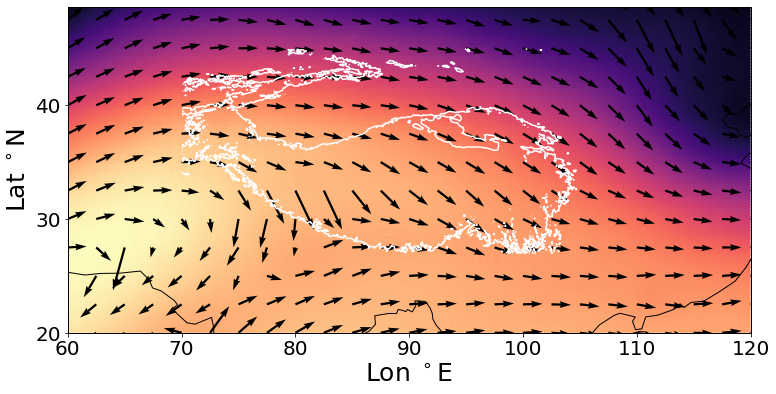

In [93]:
import quiver
import cartopy
import cartopy.feature as cfeat
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import numpy as np


idx_850hpa =1
idx_500hpa= 3
idx_300hpa= 5
level = 5 

plt.figure(figsize= (15,6))

plt.figure(figsize=(15,6))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([np.nanmin(lons),np.nanmax(lons),20,45])


# 3000 m boundary 
plt.contour(lo,la, elevation, [3000], cmap = 'Greys')


# Plot the wind speed as a contour plot

plt.pcolormesh(lons, lats,geopotential[0,3,:, :], cmap = 'magma')

# Normalise the data for uniform arrow size
u_norm = uwind[0,level,:, :]/ np.sqrt(uwind[0,level,:, :] ** 2.0 + vwind[0,3,:, :] ** 2.0)
v_norm = vwind[0,level,:, :] / np.sqrt(uwind[0,level,:, :] ** 2.0 + vwind[0,3,:, :] ** 2.0)

# Plot wind vectors 
skip  =(slice(None,None,10),slice(None,None,10))
plt.quiver(x[skip],y[skip],u_norm[skip], v_norm[skip], color ='k', transform= ccrs.PlateCarree())


# axes 
xlabels=[60,70,80,90,100,110,120]
ylabels= [20,30,40]
plt.xticks(xlabels, xlabels, fontsize=20)
plt.yticks(ylabels,ylabels, fontsize=20)
plt.xlabel('Lon $^\circ$E',  fontsize=25)
plt.ylabel('Lat $^\circ$N',  fontsize=25)

ax.coastlines()
plt.savefig('example_windvectors.png')
plt.show()